In [1]:
import numpy as np 
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
import gc

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import log_loss

import optuna
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Show all columns
pd.set_option('display.max_columns', None)

# Bold font
bold = ['\033[1m', '\033[0m']

# Read files
path = '/kaggle/input/playground-series-s3e10/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
ss = pd.read_csv(path+'sample_submission.csv')

orig_train = pd.read_csv('/kaggle/input/pulsar-classification-for-class-prediction/Pulsar.csv')

train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)
features = orig_train.columns[:-1]

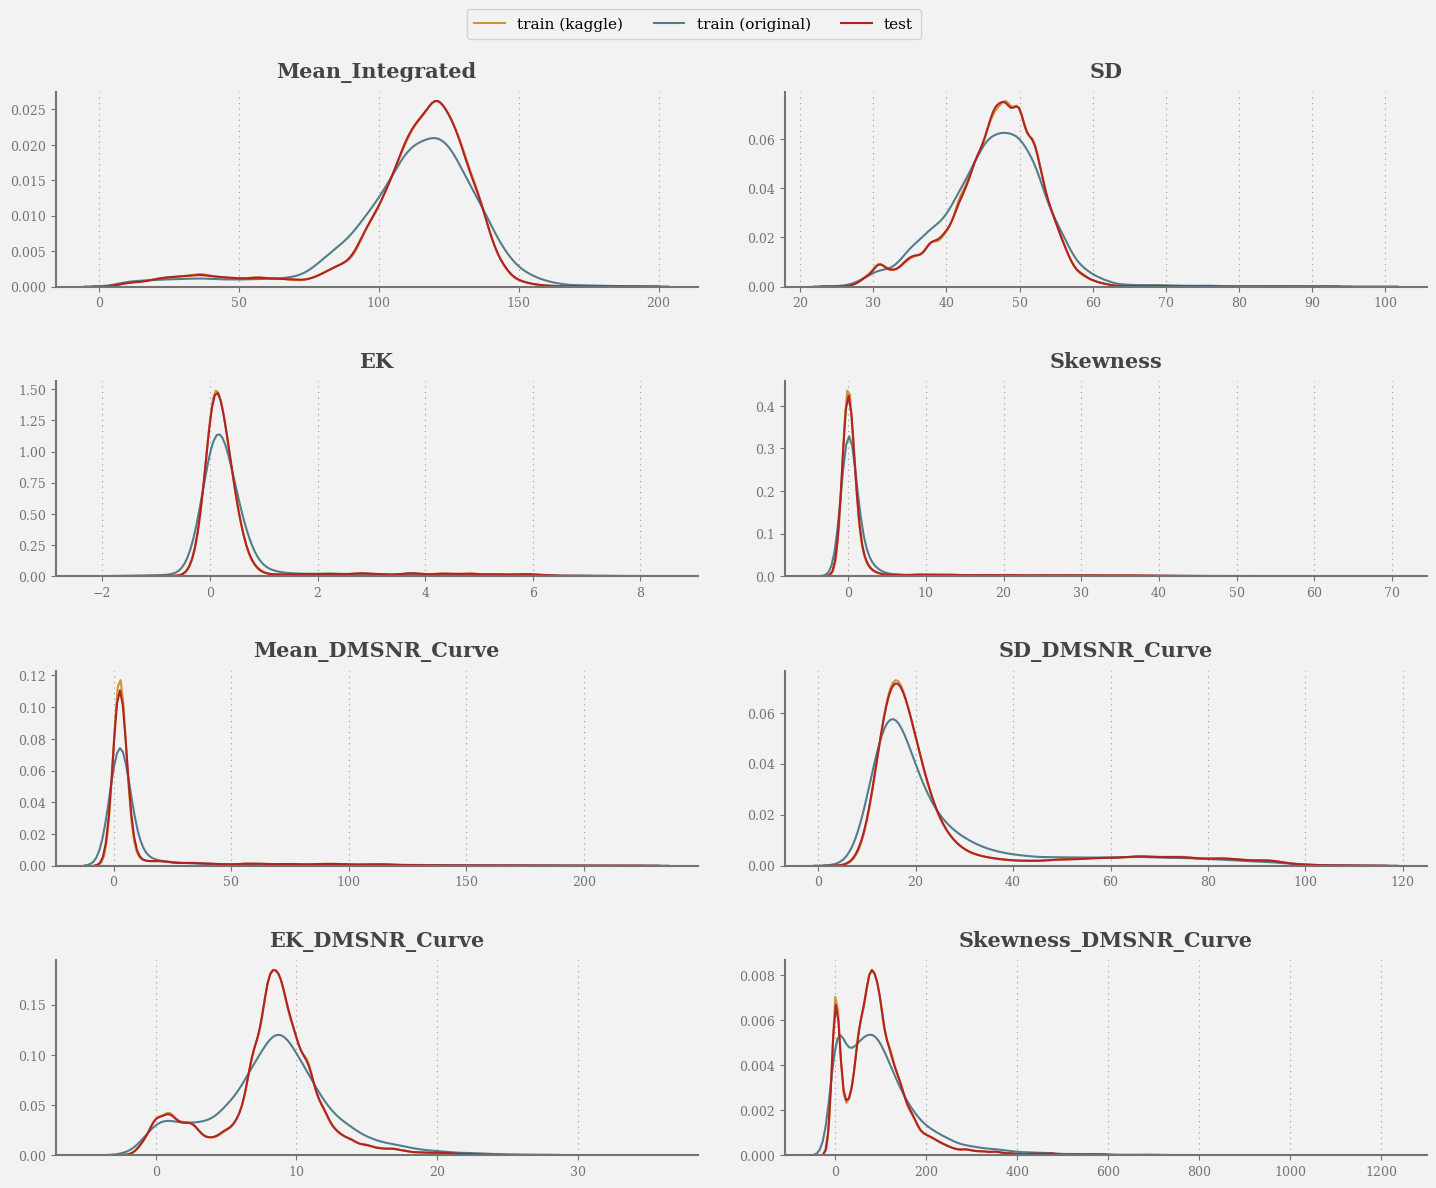

In [2]:
plt.rcParams['axes.facecolor'] = '#f2f2f2'
plt.rcParams['font.family'] = 'serif'

fig = plt.figure(figsize = (15, 12))
for i, col in enumerate(features):
    plt.subplot(4,2,i+1)
    plt.title(col, size=15, y=1.03, fontweight='bold', color='#444444')
    a = sns.kdeplot(train[col], label='train kaggle',
                    color='#cf933a', linewidth=1.5)
    sns.kdeplot(orig_train[col], label='train original',
                color='#537d8a', linewidth=1.5)
    sns.kdeplot(test[col], label='test',
                color='#b32222', linewidth=1.5)
    
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(size=9)
    plt.yticks(size=9)
    
    for s in ['right', 'top']:
        a.spines[s].set_visible(False)
    for s, axis in zip(['bottom', 'left'], ['x', 'y']):
        a.spines[s].set_color('#737373')
        a.spines[s].set_linewidth(1.5)
        a.tick_params(axis=axis, colors='#737373')
    plt.grid(color='gray', linestyle=':', axis='x', 
             alpha=0.8, zorder=0, dashes=(1,4))
    
fig.tight_layout(pad=3)
fig.legend(['train (kaggle)', 'train (original)', 'test'], 
           bbox_to_anchor=(0.64, 1.015), 
           ncol=3, borderpad=0.5, frameon=True, 
           fontsize=11, title_fontsize=12)
fig.patch.set_facecolor('#f2f2f2')
plt.show()

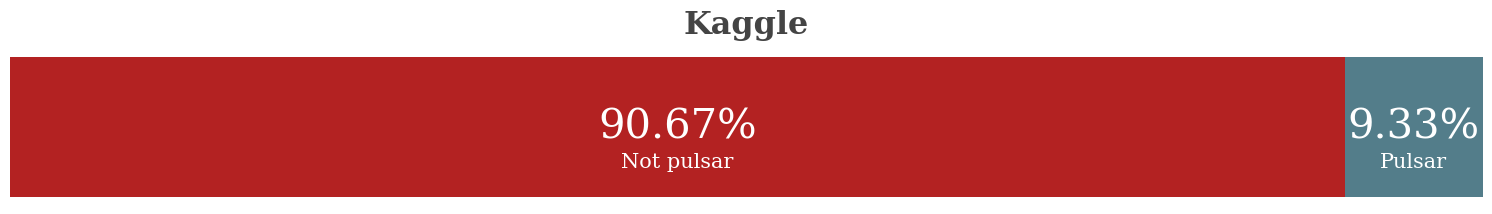

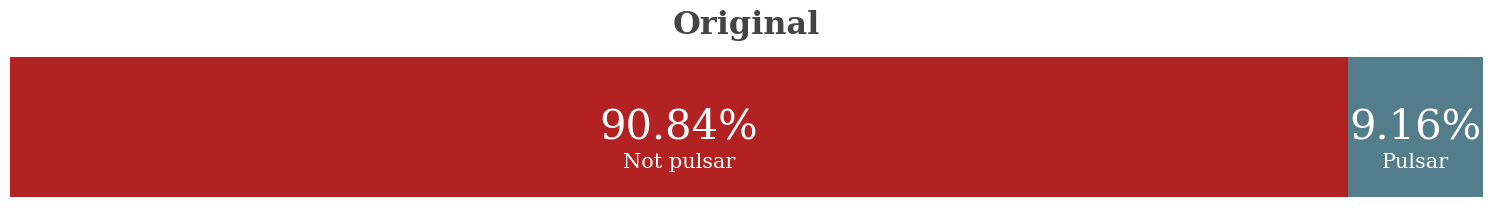

In [3]:
plt.rcParams['axes.facecolor'] = 'white'

def target_dist_plot(df, target, name):
    x = df.groupby([target])[target].count()
    y = len(df)
    r = ((x/y)).round(4)
    mf_ratio = pd.DataFrame(r).T

    fig, ax = plt.subplots(1,1,figsize=(19, 2))
    plt.title(name, size=23, y=1.05, color='#444444', fontweight='bold')

    ax.barh(mf_ratio.index, mf_ratio[0], 
            color='#b32222')
    ax.barh(mf_ratio.index, mf_ratio[1], 
            left=mf_ratio[0], 
            color='#537d8a')

    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    ax.annotate(f"{round(mf_ratio[0][target]*100,2)}%", 
                xy=(mf_ratio[0][target]/2, 0),
                va = 'center', ha='center',color='white',
                fontsize=30)

    ax.annotate('Not pulsar', xy=(mf_ratio[0][target]/2, -0.2),
                va = 'center', ha='center', color='white',
                fontsize=15)
    
    ax.annotate(f"{round(mf_ratio[1][target]*100, 2)}%", 
                xy=(mf_ratio[0][target]+mf_ratio[1][target]/2, 0),
                va = 'center', ha='center', color='white',
                fontsize=30)
    
    ax.annotate('Pulsar', xy=(mf_ratio[0][target]+mf_ratio[1][target]/2, -0.2),
                va = 'center', ha='center', color='white',
                fontsize=15)

    for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_visible(False)
    plt.show()
    
target_dist_plot(train, 'Class', 'Kaggle')
print()
target_dist_plot(orig_train, 'Class', 'Original')

plt.rcParams['axes.facecolor'] = '#f2f2f2'

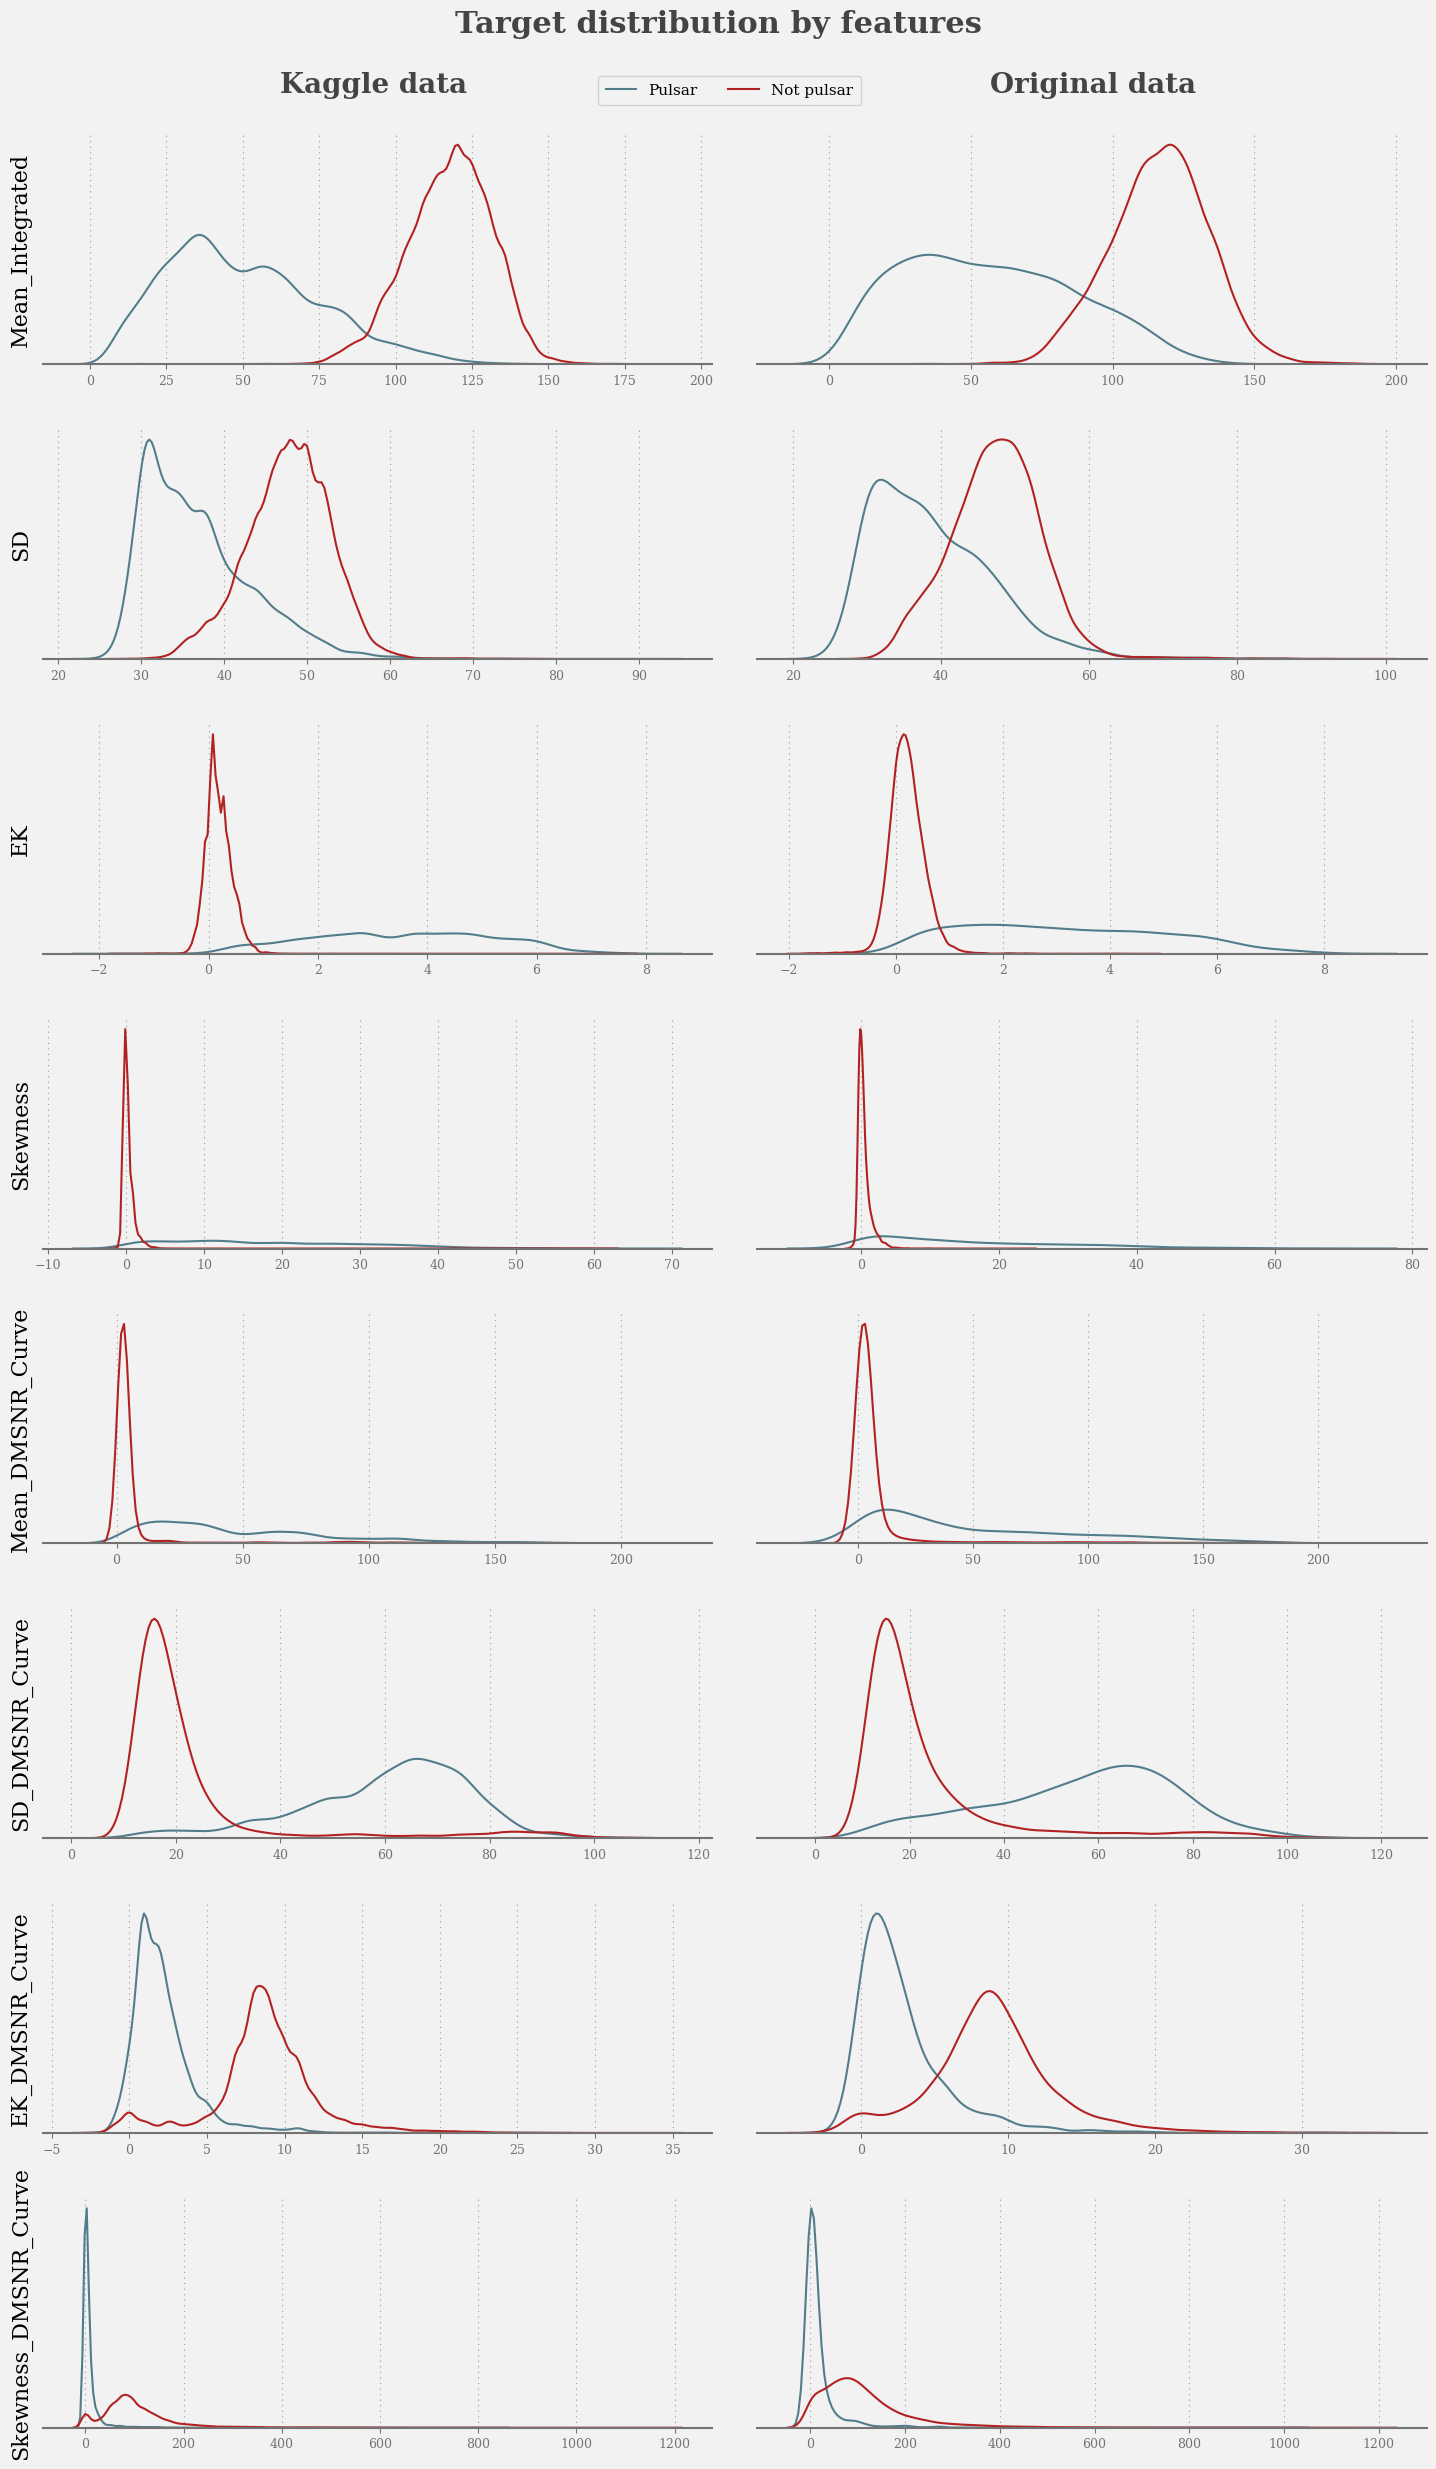

In [4]:
fig = plt.figure(figsize = (15, 24))
for i, col in zip([1,3,5,7,9,11,13,15],
                  features):
    for k, df in enumerate([train, orig_train]):
        plt.subplot(8,2,i+k)
        a = sns.kdeplot(df[df['Class']==1][col], label='Pulsar',
                        color='#537d8a', linewidth=1.5)
        sns.kdeplot(df[df['Class']==0][col], label='Not pulsar',
                    color='#b32222', linewidth=1.5)
        if k == 0:
            plt.ylabel(col, size=16)
        else:
            plt.ylabel('')
        plt.xlabel('')
        plt.xticks(size=9)
        plt.yticks([])

        for s in ['right', 'top', 'left']:
            a.spines[s].set_visible(False)
        for s, axis in zip(['bottom'], ['x']):
            a.spines[s].set_color('#737373')
            a.spines[s].set_linewidth(1.5)
            a.tick_params(axis=axis, colors='#737373')
        plt.grid(color='gray', linestyle=':', axis='x', 
                 alpha=0.8, zorder=0, dashes=(1,4))
        
fig.tight_layout(pad=3)
fig.legend(['Pulsar', 'Not pulsar'], 
           bbox_to_anchor=(0.6, 1.01), 
           ncol=2, borderpad=0.5, frameon=True, 
           fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.025, 'Target distribution by features', 
            fontweight='bold',size=22, color='#444444', ha='center') 
plt.figtext(0.27, 1, 'Kaggle data', 
            fontweight='bold',size=20, color='#444444', ha='center') 
plt.figtext(0.75, 1, 'Original data', 
            fontweight='bold',size=20, color='#444444', ha='center') 
fig.patch.set_facecolor('#f2f2f2')
plt.show()

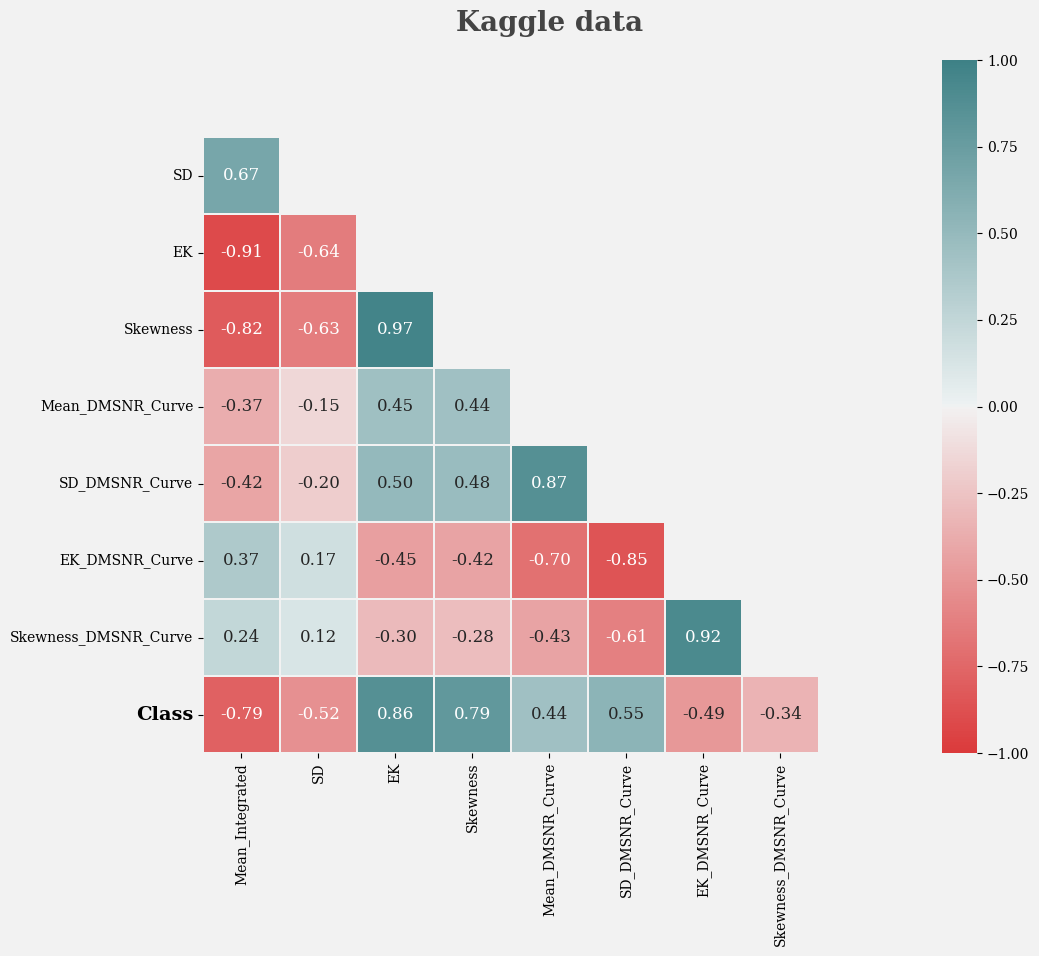

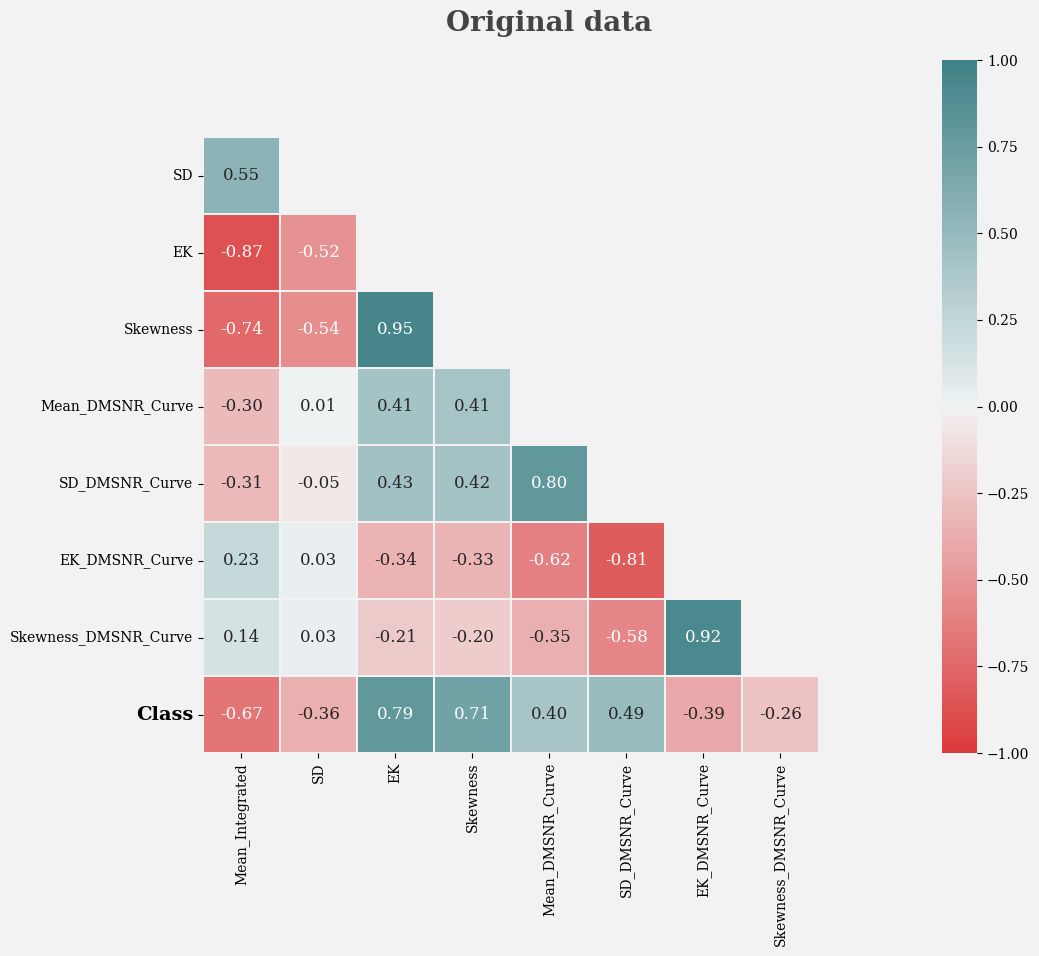

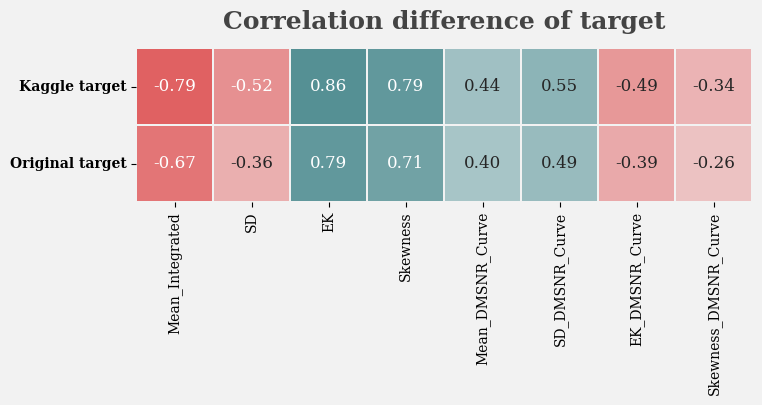

In [5]:
### Correlation maps ###
def corr_map(df, title):
    corr = df.corr()
    mask = np.triu(corr)
    fig = plt.figure(figsize=(12, 9))
    a = sns.heatmap(
        corr, 
        mask=mask, 
        annot=True, 
        square=True,
        annot_kws={'fontsize': 12}, 
        cbar=True,
        cmap=sns.diverging_palette(372, 200, as_cmap=True), 
        vmin=-1, 
        vmax=1, 
        fmt='.2f', 
        linewidths=0.2, 
        linecolor='#f2f2f2'
    )
    plt.title(title, size=20, y=1.03, fontweight='bold', color='#444444')
    plt.xticks(size=10)
    plt.yticks(size=10)
    a.collections[0].colorbar.ax.tick_params(labelsize=10)
    a.set_xticks(a.get_xticks()[:-1])
    a.set_yticks(a.get_yticks()[1:])
    plt.yticks()[-1][-1].set_fontsize(14)
    plt.yticks()[-1][-1].set_fontweight('bold')
    fig.patch.set_facecolor('#f2f2f2')
    plt.show()
    
corr_map(train, "Kaggle data")
corr_map(orig_train, "Original data")

### Correlation difference of target ###
corr1 = train.corr().tail(1).reset_index().replace({'Class': 'Kaggle target'}).set_index('index')
corr2 = orig_train.corr().tail(1).reset_index().replace({'Class': 'Original target'}).set_index('index')
corr1 = pd.concat([corr1, corr2]).drop('Class', axis=1)
corr1.index.rename('', inplace=True)
fig = plt.figure(figsize=(12, 2))
a = sns.heatmap(
    corr1, 
    annot=True, 
    square=True,
    annot_kws={'fontsize': 12}, 
    cbar=False,
    cmap=sns.diverging_palette(372, 200, as_cmap=True), 
    vmin=-1, 
    vmax=1, 
    fmt='.2f', 
    linewidths=0.2, 
    linecolor='#f2f2f2'
)
plt.title('Correlation difference of target', size=18, y=1.07, fontweight='bold', color='#444444')
plt.xticks(size=10)
plt.yticks(size=10)
plt.yticks()[-1][0].set_fontweight('bold')
plt.yticks()[-1][1].set_fontweight('bold')
fig.patch.set_facecolor('#f2f2f2')
plt.show()

In [6]:
colors = ['#b32222', '#537d8a']
names = ['Not pulsar', 'Pulsar']

fig = go.Figure()
for target, color, name in zip([0, 1], colors, names):
    fig.add_trace(
        go.Scatter3d(
            x=orig_train[orig_train['Class']==target]['Mean_Integrated'],
            y=orig_train[orig_train['Class']==target]['EK'],
            z=orig_train[orig_train['Class']==target]['Skewness'],
            mode='markers',
            name=name,
            marker=dict(size=3, color=color, opacity=0.7)
        )
    )

fig.update_traces(hovertemplate='Mean_Integrated: %{x} <br>EK: %{y} <br>Skewness: %{z}')

fig.update_layout(
    width=750, 
    height=750, 
    autosize=True, 
    showlegend=False,
    scene=dict(
        xaxis=dict(title='Mean integrated', titlefont_color='#444444'),
        yaxis=dict(title = 'EK', titlefont_color='#444444'),
        zaxis=dict(title='Skewness', titlefont_color='#444444')
    ),
    font=dict(family='serif', color='#444444', size=14),
    title=dict(text='<b>Class distribution by most correlated features</b>',
               x=0.5, font_size=22)
)

fig.show()

In [7]:
train = pd.concat([train, orig_train[orig_train['Class']==1]], axis=0, ignore_index=True)

# Pulsar outliers | 6 outliers (4 from Kaggle + 2 from original)
outliers = train[
    (train['Class']==1)&
    (train['Mean_Integrated']>115)&
    (train['SD']>45)&
    (train['EK']<0.03)&
    (train['Skewness']<1)&
    (train['Mean_DMSNR_Curve']<20)
].index

train.drop(outliers, axis=0, inplace=True)

X = train.drop('Class', axis=1)
y = train['Class']

FOLDS = 5
seed = 228
np.random.seed(seed)

In [8]:
xgb_params = {
    'max_depth': 6,
    'eta': 0.01,
    'colsample_bytree': 0.71,
    'subsample': 0.8573,
    'min_child_weight': 7,
    'lambda': 30,
    'gamma': 0.9882,
        
    'seed': seed,
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

predictions, scores = np.zeros(len(test)), []
k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    dtrain = xgb.DMatrix(
        data=X.iloc[train_idx], 
        label=y.iloc[train_idx]
    )
    
    dvalid = xgb.DMatrix(
        data=X.iloc[val_idx], 
        label=y.iloc[val_idx]
    )

    model = xgb.train(
        params=xgb_params, 
        dtrain=dtrain, 
        num_boost_round=10000,
        verbose_eval=False,
        evals=[(dtrain, 'train'), 
               (dvalid, 'eval')], 
        callbacks=[xgb.callback.EarlyStopping(rounds=500,
                                              data_name='eval',
                                              maximize=False,
                                              save_best=True)]
    )
    
    val_preds = model.predict(dvalid)
    val_score = log_loss(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(xgb.DMatrix(test)) / FOLDS
    print(f'FOLD {fold+1} | LogLoss: {round(val_score, 4)}')
    
    del dtrain, dvalid, val_preds, val_score, model
    gc.collect()

print('*'*25)
print(f'Final LogLoss: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')
xgb_preds = predictions.copy()

FOLD 1 | LogLoss: 0.0344
FOLD 2 | LogLoss: 0.0405
FOLD 3 | LogLoss: 0.0348
FOLD 4 | LogLoss: 0.0388
FOLD 5 | LogLoss: 0.0348
*************************
Final LogLoss: 0.036653


In [9]:
lgb_params = {
    'max_depth': 6,
    'learning_rate': 0.01,
    'min_data_in_leaf': 71, 
    'num_leaves': 11, 
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.6423, 
    'bagging_freq': 11, 
    'lambda_l2': 29,
    
    'seed': seed,
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'device': 'cpu', 
    'n_jobs': -1,
    'metric': 'binary_logloss',
    'verbose': -1
}

predictions, scores = np.zeros(len(test)), []
k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    lgb_train = lgb.Dataset(
        data=X.iloc[train_idx], 
        label=y.iloc[train_idx]
    )

    lgb_valid = lgb.Dataset(
        data=X.iloc[val_idx], 
        label=y.iloc[val_idx],
        reference=lgb_train
    )

    model = lgb.train(
        params=lgb_params, 
        train_set=lgb_train, 
        num_boost_round=10000,
        valid_sets=[lgb_train, lgb_valid], 
        valid_names=['train', 'val'],
        verbose_eval=False,
        callbacks=[lgb.log_evaluation(False),
                   lgb.early_stopping(300, verbose=False)]
    )

    b_itr = model.best_iteration
    val_preds = model.predict(X.iloc[val_idx], num_iteration=b_itr)
    val_score = log_loss(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test, num_iteration=b_itr) / FOLDS
    print(f'FOLD {fold+1} | LogLoss: {round(val_score, 4)}')
        
    del lgb_train, lgb_valid, val_preds, val_score, model
    gc.collect()

print('*'*25)
print(f'Final LogLoss: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')
lgb_preds = predictions.copy()

FOLD 1 | LogLoss: 0.0346
FOLD 2 | LogLoss: 0.0399
FOLD 3 | LogLoss: 0.0349
FOLD 4 | LogLoss: 0.0386
FOLD 5 | LogLoss: 0.0348
*************************
Final LogLoss: 0.036559


In [10]:
cb_params = {
    'depth': 6,
    'learning_rate': 0.01,
    'rsm': 0.62,
    'subsample': 0.8577,
    'l2_leaf_reg': 94,
    'min_data_in_leaf': 52,
    'random_strength': 1.6152,
    
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'random_seed': seed,
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss'
}

predictions, scores = np.zeros(len(test)), []
k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    
    cb_train = cb.Pool(
        data=X.iloc[train_idx],
        label=y.iloc[train_idx]
    )

    cb_valid = cb.Pool(
        data=X.iloc[val_idx],
        label=y.iloc[val_idx]
    )

    model = cb.train(
        params=cb_params,
        dtrain=cb_train,
        evals=cb_valid,
        num_boost_round=30000, 
        early_stopping_rounds=300,
        verbose=False
    )
    
    val_preds = model.predict(cb_valid, prediction_type='Probability')[:,1]
    val_score = log_loss(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test, prediction_type='Probability')[:,1] / FOLDS
    print(f'FOLD {fold+1} | LogLoss: {round(val_score, 4)}')
    
    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('*'*25)
print(f'Final LogLoss: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')
cb_preds = predictions.copy()

FOLD 1 | LogLoss: 0.0349
FOLD 2 | LogLoss: 0.0404
FOLD 3 | LogLoss: 0.0347
FOLD 4 | LogLoss: 0.0385
FOLD 5 | LogLoss: 0.035
*************************
Final LogLoss: 0.036691


In [11]:
def norm_0to1(preds):
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

xgb_preds = norm_0to1(xgb_preds)
lgb_preds = norm_0to1(lgb_preds)
cb_preds = norm_0to1(cb_preds)

ss['Class'] = (xgb_preds+lgb_preds+cb_preds)/3
ss.to_csv('submission.csv', index=False)
ss

,id,Class
0,117564,0.000111
1,117565,0.002447
2,117566,0.000104
3,117567,0.141978
4,117568,0.003546
...,...,...
78372,195936,0.000519
78373,195937,0.000069
78374,195938,0.000155
78375,195939,0.061809
